<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Bayesian_Hierarchical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hierarchicalforecast
!pip install statsforecast
!pip install datasetsforecast
!pip install nixtlats>=0.1.0
!pip install darts
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=4b178ff9d7f0e3f29f9a192ea6cacc3843b82ba1eb5838e1eea626213d1d6ac8
  Stored in directory: /root/.cache/pip/wheels/5a/b5/4e/216953a1c711da55de29ed7ecf158b4a5bf32ef93d69ad66dd
Successfully built fugue-sql-antlr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 8.4 MB/s eta 0

In [2]:
########################
# PACKAGES
########################
# !pip install -U numba statsforecast datasetsforecast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
import pymc as pm

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoCES, AutoTheta

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination, ERM
from hierarchicalforecast.utils import aggregate

# #obtain hierarchical dataset
# from datasetsforecast.hierarchical import HierarchicalData
from nixtlats import TimeGPT
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

import pandas as pd
from darts import TimeSeries
from darts.models import RegressionModel
from darts.dataprocessing.transformers import Scaler
from lightgbm import LGBMRegressor
from darts.metrics import mae, rmse
from darts.models import LightGBMModel
from darts import concatenate
pd.options.display.float_format = '{:,.2f}'.format

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
##############
# PARAMS
##############
fct_periods = 12
fct_st_date = '2023-04-01'
fct_end_date = '2023-12-01'

# Create hierarchical structure and constraints
hierarchy_levels = [['top_level'],
                    ['top_level', 'level2'],
                    ['top_level', 'level2', 'level3'],
                    ['top_level', 'level2', 'level3', 'bottom_level']]

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/regional_hierarchy.csv'
r_hier = pd.read_csv(inputFile)


In [17]:
def prepare_data(data, r_hier):
    # Merge hierarchy
    data = data.merge(r_hier, how='left', left_on='cost_object', right_on='cost_object')

    # Transform date and y
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].astype(float)

    # Address NA values
    data['volume'] = data['y'].fillna(0)
    data['region'] = data['region'].fillna('')
    data['cost_object'] = data['cost_object'].fillna('')
    data['product'] = data['product'].fillna('')

    # Create hierarchical dataframe
    data['top_level'] = 'global'  # Assuming 'top_level' does not contain '/', otherwise add a replace line for it too.
    data.rename(columns={'region': 'level2', 'cost_object': 'level3', 'product': 'bottom_level'}, inplace=True)
    data = data[['level2', 'level3', 'bottom_level', 'top_level', 'ds', 'y']]

    # Replace '/' with '_' in the four columns
    data['level2'] = data['level2'].str.replace('/', '_')
    data['level3'] = data['level3'].str.replace('/', '_')
    data['bottom_level'] = data['bottom_level'].str.replace('/', '_')

    data['unique_id'] = data['top_level'] + '/' + data['level2'] + '/' + data['level3'] + '/' + data['bottom_level']

    return data

def convert_fct2df(forecasts):
    forecast_dfs = []
    for unique_id, forecast_ts in forecasts.items():
        df = forecast_ts.pd_dataframe()
        df['unique_id'] = unique_id
        forecast_dfs.append(df)

    # Concatenate all forecast DataFrames into a single DataFrame
    all_forecasts_df = pd.concat(forecast_dfs, axis=0)
    all_forecasts_df.reset_index(inplace=True)

    # Reorder and rename columns as needed
    all_forecasts_df = all_forecasts_df[['unique_id', 'ds', 'y']]
    all_forecasts_df.columns.name = None

    return all_forecasts_df

In [5]:
##############
# DATA LOAD
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
budget = pd.read_csv(inputFile)
budget = budget[budget['category']=='EQUIV_UNIT - Equivalent Units']
budget.rename(columns={'country': 'cost_object'}, inplace=True)
budget = prepare_data(budget, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_output.csv'
volume_act = pd.read_csv(inputFile)
volume_act.rename(columns={'value': 'y'}, inplace=True)
volume_act = prepare_data(volume_act, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/ids2smooth.csv'
ids2smooth = pd.read_csv(inputFile)

In [7]:
# Subset
# regs2include = ['US10 - Astellas Pharma US, Inc.', 'US21 - Agensys, Inc.', 'JP10 - Astellas Pharma Inc']
# volume_act = volume_act[volume_act['level3'].isin(regs2include)]

level2include = ['Japan', 'West Europe', 'North America']
volume_act = volume_act[volume_act['level2'].isin(level2include)]

In [8]:
########################
# IDENTIFY UNIVERSE
########################
tested_ts = set(budget['unique_id'].unique()).intersection(volume_act['unique_id'].unique())

# Find unique IDs present in budget_h but not in rev
unique_ids_in_budget_not_in_rev = set(budget['unique_id'].unique()).difference(volume_act['unique_id'].unique())

# Find unique IDs present in rev but not in budget_h
unique_ids_in_rev_not_in_budget = set(volume_act['unique_id'].unique()).difference(budget['unique_id'].unique())

# Filter volume
volume_act = volume_act[volume_act['unique_id'].isin(tested_ts)]

In [9]:
########################
# TIME SERIES TYPES
########################
# new_products = ['ENFORTUMAB - Enforumab Vedotin', 'ROXADUSTNT - Roxadustant', 'GILTERITNB - Gilteritinib']
# loe_products = ['MICAFUNGIN - Micafungin Sodium']

# volume_np_act = volume_act[volume_act['bottom_level'].isin(new_products)]
# volume_loe_act = volume_act[volume_act['bottom_level'].isin(loe_products)]

# # Remove from original
# volume_act = volume_act[~(volume_act['bottom_level'].isin(new_products + loe_products))]

In [10]:
########################
# INTERMITTENT DEMAND
########################

# Function to calculate the percentage of zeros after the first non-zero
def calculate_percentage_zeros(df):
    # Find the index of the first non-zero entry in 'y'
    first_non_zero_index = df.loc[df['y'] != 0].index.min()
    # If there are no non-zero values, return None or 0 based on your preference
    if pd.isna(first_non_zero_index):
        return None  # Or return 0 if you want to treat this as 0% zeros following non-zero
    # Select the subset of 'y' after the first non-zero
    post_non_zero_series = df.loc[first_non_zero_index:, 'y']
    # Count the number of zeros in this subset
    num_zeros = (post_non_zero_series == 0).sum()
    # Calculate the percentage of zeros
    percentage_zeros = num_zeros / len(post_non_zero_series) * 100
    return percentage_zeros

# Apply the function to each group and reset index to make unique_id a column
percentage_zeros_df = volume_act.groupby('unique_id').apply(calculate_percentage_zeros).reset_index(name='percentage_zeros')

percentage_zeros_df


,unique_id,percentage_zeros
0,global/Japan/JP10 - Astellas Pharma Inc/ACLARB...,0.0
1,global/Japan/JP10 - Astellas Pharma Inc/BELZER...,0.0
2,global/Japan/JP10 - Astellas Pharma Inc/BIXALO...,0.0
3,global/Japan/JP10 - Astellas Pharma Inc/BLINAT...,0.0
4,global/Japan/JP10 - Astellas Pharma Inc/CERTOL...,0.0
...,...,...
136,global/West Europe/D_E_SWITZ - Switzerland/ROX...,NaN
137,global/West Europe/D_E_SWITZ - Switzerland/SOL...,0.0
138,global/West Europe/D_E_SWITZ - Switzerland/TAC...,0.0
139,global/West Europe/D_E_SWITZ - Switzerland/TAC...,0.0


In [11]:
########################
# CANDIDATES FOR AUTO-ARIMA
########################
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to test stationarity with handling for constant series
def test_stationarity(timeseries):
    # Check if the series is constant
    if np.all(timeseries == timeseries.iloc[0]):
        return 'constant'  # Return 'constant' if all values in the series are the same

    # Perform Dickey-Fuller test otherwise:
    dftest = adfuller(timeseries, autolag='AIC')
    # Return True if series is stationary, False otherwise
    return dftest[1] <= 0.05

# Function to difference the series
def difference_series(timeseries):
    return timeseries.diff().dropna()

# Your original dataframe
df = volume_act

# Prepare a DataFrame to store the results
results_df = pd.DataFrame(columns=['unique_id', 'original_stationary', 'differenced_stationary'])

# Loop through each unique_id
for unique_id in df['unique_id'].unique():
    # Extract the time series for the current unique_id
    sub_series = df[df['unique_id'] == unique_id].set_index('ds')['y']

    # Test for stationarity on the original series
    original_stationary = test_stationarity(sub_series)

    # Initialize differenced_stationary as None (it will stay None if differencing is not needed)
    differenced_stationary = None

    # If the original series is not stationary, difference the series and test again
    if not original_stationary:
        differenced_series = difference_series(sub_series)
        differenced_stationary = test_stationarity(differenced_series)

    # Append the results to the results DataFrame
    results_df = results_df.append({'unique_id': unique_id,
                                    'original_stationary': original_stationary,
                                    'differenced_stationary': differenced_stationary},
                                   ignore_index=True)


<ipython-input-11-86ea403fa3c9>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'unique_id': unique_id,
<ipython-input-11-86ea403fa3c9>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'unique_id': unique_id,
<ipython-input-11-86ea403fa3c9>:45: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append({'unique_id': unique_id,
<ipython-input-11-86ea403fa3c9>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'unique_id': unique_id,
<ipython-input-11-86ea403fa3c9>:45: FutureWarning: I

In [12]:
########################
# SEGMENT TIME SERIES
########################
inter_demand_list = percentage_zeros_df[percentage_zeros_df['percentage_zeros']>=50]['unique_id'].tolist()

original_stationary_list = results_df[results_df['original_stationary']==True]['unique_id'].tolist()
differenced_stationary_list = results_df[(results_df['original_stationary']==False) & (results_df['differenced_stationary']==True)]['unique_id'].tolist()

auto_arima_list = [item for item in original_stationary_list if item not in inter_demand_list]

In [13]:
########################
# SMOOTH DATA
########################
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm

# # Filter
# volume_act_sm = volume_act[volume_act['unique_id'].isin(ids2smooth['unique_id'])]

# # Columns to smooth
# columns_to_smooth = ['y']

# # New column names for the smoothed data
# new_columns = ['Smoothed_y']

# # Iterate through each unique ID
# for unique_id in volume_act_sm['unique_id'].unique():
#     # Filter the DataFrame for the current ID
#     temp_df = volume_act_sm[volume_act_sm['unique_id'] == unique_id]

#     # Iterate through each column to smooth
#     for col, new_col in zip(columns_to_smooth, new_columns):
#         # Ensure the time series is a pandas Series (assuming 'ds' is the datetime column)
#         time_series = pd.Series(temp_df[col].values, index=pd.to_datetime(temp_df['ds']))

#         # Set up and fit the model
#         model = sm.tsa.UnobservedComponents(time_series, 'local linear trend')
#         print(unique_id)
#         results = model.fit()

#         # Get the smoothed series
#         smoothed_series = results.smoothed_state[0]

#         # Ensure smoothed values are non-negative
#         smoothed_series = np.maximum(smoothed_series, 0)

#         # Adjust the smoothed series to maintain the original sum
#         original_sum = time_series.sum()
#         smoothed_sum = smoothed_series.sum()
#         if smoothed_sum > 0:  # Prevent division by zero
#             adjustment_factor = original_sum / smoothed_sum
#             adjusted_smoothed_series = smoothed_series * adjustment_factor
#         else:
#             adjusted_smoothed_series = smoothed_series  # Keep original if smoothed sum is zero

#         # Store the adjusted smoothed series back in the DataFrame
#         # Note: We're using 'temp_df.index' to ensure the indices match
#         volume_act_sm.loc[temp_df.index, new_col] = adjusted_smoothed_series

# # After looping, 'sga_output2' will contain the new adjusted smoothed columns
# volume_act_sm = volume_act_sm[['unique_id', 'ds', 'Smoothed_y']]
# volume_act_sm.columns = ['unique_id', 'ds', 'y']

# # Re-add non smoothed
# volume_act_smx = volume_act[~(volume_act['unique_id'].isin(ids2smooth['unique_id'])) & (volume_act['unique_id'].isin(budget['unique_id'])) & (volume_act['unique_id'].isin(tested_ts))]

# # Concat
# volume_act2 = pd.concat([volume_act_smx, volume_act_sm])

In [14]:
########################
# RUN AUTO ARIMA
########################
# # volume_act2 = volume_act[volume_act['unique_id'].isin(auto_arima_list)]
# volume_act2 = volume_act

# #split train/test sets
# test  = volume_act2.groupby('unique_id').tail(fct_periods)
# train = volume_act2.drop(test.index)

# models=[AutoETS(season_length=12), AutoARIMA(season_length = 12), AutoTheta(season_length = 12)]
# # models=[AutoARIMA(season_length = 12)]
# # models=[AutoETS(season_length=12)]

# # Compute base predictions
# fcst = StatsForecast(df=train[['unique_id', 'ds', 'y']],
#                      models=models,
#                      freq='MS', n_jobs=-1)

# volume_fct = fcst.forecast(h=fct_periods)

# volume_fct['Forecast'] = volume_fct[['AutoETS', 'AutoARIMA', 'AutoTheta']].mean(axis=1)
# volume_fct = volume_fct[['unique_id', 'ds', 'Forecast']]

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: divide by zero encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags

In [15]:
# Import necessary libraries
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import rmse

# Assuming 'df' is your DataFrame
time_series_dfs = {uid: group for uid, group in train.groupby('unique_id')}

# Split into training and testing sets, convert to TimeSeries objects
train_series_dict = {}
test_series_dict = {}
for uid, group in time_series_dfs.items():
    # Let's say we use the last N points for testing, the rest for training
    N = 12  # Adjust N based on your forecast horizon or test set size
    train_df, test_df = group[:-N], group[-N:]
    train_series_dict[uid] = TimeSeries.from_dataframe(train_df, 'ds', 'y')
    test_series_dict[uid] = TimeSeries.from_dataframe(test_df, 'ds', 'y')

# Fit the model and compute RMSE for each series
rmse_results = {}
for uid, train_series in train_series_dict.items():
    model = ExponentialSmoothing()
    model.fit(train_series)
    forecast = model.predict(len(test_series_dict[uid]))
    rmse_results[uid] = rmse(test_series_dict[uid], forecast)

# Create a DataFrame from the RMSE results
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['unique_id', 'RMSE'])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

In [99]:
# Import necessary libraries
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, StatsForecastAutoETS
from darts.metrics import mae, mape

train2 = train[train['unique_id'].isin(['global/Japan/JP10 - Astellas Pharma Inc/ENZA - Enzalutamide', 'global/North America/US10 - Astellas Pharma US, Inc./ENZA - Enzalutamide', 'global/West Europe/D_E_FRANCE - France/ROXADUSTNT - Roxadustant'])]

time_series_dfs = {uid: group for uid, group in train.groupby('unique_id')}

filtered_time_series_dfs = {}
for uid, group in time_series_dfs.items():
    # Find the index of the first non-zero value
    non_zero_index = group['y'].ne(0).idxmax()

    # Determine the start index for filtering to ensure at least 13 data points
    start_index = max(0, non_zero_index - (13 - 1))  # Ensure there are at least 13 data points

    if group.loc[non_zero_index:].shape[0] < 13:
        filtered_df = group.loc[start_index:]
    else:
        filtered_df = group.loc[non_zero_index:]

    # Check if the resulting dataframe is not empty
    if not filtered_df.empty:
        filtered_time_series_dfs[uid] = filtered_df



# Convert each filtered DataFrame into a Darts TimeSeries object
time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in filtered_time_series_dfs.items()}

# Create and fit an ETS model for each time series
ets_models = {}
mape_values = {}

for uid, series in time_series_dict.items():
    model = StatsForecastAutoETS()
    model.fit(series)
    ets_models[uid] = model

    # Test Model
    historical_fcast = model.historical_forecasts(series, train_length=12, forecast_horizon=1, verbose=True, retrain=True, last_points_only=True)
    print(uid)
    current_mape = round(mape(historical_fcast, series),2)  # Compute MAPE value
    mape_values[uid] = current_mape  # Store the MAPE value in the dictionary

# Forecasting (assuming you want to forecast the next N steps)
N = 12
forecasts = {uid: model.predict(N) for uid, model in ets_models.items()}

ets_fct = convert_fct2df(forecasts)
mape_df = pd.DataFrame(list(mape_values.items()), columns=['unique_id', 'MAPE'])
mape_df

100%|██████████| 32/32 [00:01<00:00, 29.56it/s]


global/Japan/JP10 - Astellas Pharma Inc/ACLARBICIN - ACLARBICIN


100%|██████████| 9/9 [00:00<00:00, 54.25it/s]


global/Japan/JP10 - Astellas Pharma Inc/BELZER - BELZER


100%|██████████| 32/32 [00:00<00:00, 37.15it/s]


global/Japan/JP10 - Astellas Pharma Inc/BIXALOMER - BIXALOMER


100%|██████████| 32/32 [00:00<00:00, 38.69it/s]


global/Japan/JP10 - Astellas Pharma Inc/BLINATUMOM - BLINATUMOM


100%|██████████| 32/32 [00:00<00:00, 38.05it/s]


global/Japan/JP10 - Astellas Pharma Inc/CERTOLIZUM - CERTOLIZUM


100%|██████████| 2/2 [00:00<00:00, 41.27it/s]


global/Japan/JP10 - Astellas Pharma Inc/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:01<00:00, 35.96it/s]


global/Japan/JP10 - Astellas Pharma Inc/ENZA - Enzalutamide


100%|██████████| 32/32 [00:00<00:00, 44.39it/s]


global/Japan/JP10 - Astellas Pharma Inc/EVOLOCUMAB - EVOLOCUMAB


100%|██████████| 32/32 [00:00<00:00, 61.95it/s]


global/Japan/JP10 - Astellas Pharma Inc/GABAPENTIN - GABAPENTIN


100%|██████████| 32/32 [00:00<00:00, 62.58it/s]


global/Japan/JP10 - Astellas Pharma Inc/GARENOXACI - GARENOXACI


100%|██████████| 38/38 [00:00<00:00, 61.80it/s]


global/Japan/JP10 - Astellas Pharma Inc/GILTERITNB - Gilteritinib


100%|██████████| 32/32 [00:00<00:00, 101.47it/s]


global/Japan/JP10 - Astellas Pharma Inc/INFLUENZA - INFLUENZA


100%|██████████| 43/43 [00:00<00:00, 65.96it/s]


global/Japan/JP10 - Astellas Pharma Inc/IPRAGLIF - Ipragliflozin


100%|██████████| 16/16 [00:00<00:00, 69.99it/s]


global/Japan/JP10 - Astellas Pharma Inc/LINACLOTID - LINACLOTID


100%|██████████| 32/32 [00:00<00:00, 63.79it/s]


global/Japan/JP10 - Astellas Pharma Inc/MEPENZOLAT - MEPENZOLAT


100%|██████████| 43/43 [00:00<00:00, 44.06it/s]


global/Japan/JP10 - Astellas Pharma Inc/MICAFUNGIN - Micafungin Sodium


100%|██████████| 16/16 [00:00<00:00, 39.86it/s]


global/Japan/JP10 - Astellas Pharma Inc/MINODRONAT - MINODRONAT


100%|██████████| 43/43 [00:01<00:00, 42.80it/s]


global/Japan/JP10 - Astellas Pharma Inc/MIRABEGRON - Mirabegron


100%|██████████| 9/9 [00:00<00:00, 75.00it/s]


global/Japan/JP10 - Astellas Pharma Inc/NATEGLINID - NATEGLINID


100%|██████████| 32/32 [00:00<00:00, 63.92it/s]


global/Japan/JP10 - Astellas Pharma Inc/NITISINONE - NITISINONE


100%|██████████| 16/16 [00:00<00:00, 42.63it/s]


global/Japan/JP10 - Astellas Pharma Inc/PEFICITINI - PEFICITINI


100%|██████████| 32/32 [00:00<00:00, 51.67it/s]


global/Japan/JP10 - Astellas Pharma Inc/POLYCARBOP - POLYCARBOP


100%|██████████| 32/32 [00:00<00:00, 67.19it/s]


global/Japan/JP10 - Astellas Pharma Inc/QUETIAPINE - QUETIAPINE


100%|██████████| 9/9 [00:00<00:00, 95.47it/s]


global/Japan/JP10 - Astellas Pharma Inc/RAMOS_IRR - RAMOS_IRR


100%|██████████| 32/32 [00:00<00:00, 62.11it/s]


global/Japan/JP10 - Astellas Pharma Inc/ROMOSOZUMA - ROMOSOZUMA


100%|██████████| 16/16 [00:00<00:00, 56.02it/s]


global/Japan/JP10 - Astellas Pharma Inc/ROXADUSTNT - Roxadustant


100%|██████████| 9/9 [00:00<00:00, 83.44it/s]


global/Japan/JP10 - Astellas Pharma Inc/SERESCUE - SERESCUE


100%|██████████| 16/16 [00:00<00:00, 55.26it/s]


global/Japan/JP10 - Astellas Pharma Inc/SITAG_IPRA - SITAG_IPRA


100%|██████████| 43/43 [00:00<00:00, 58.55it/s]


global/Japan/JP10 - Astellas Pharma Inc/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 60.24it/s]


global/Japan/JP10 - Astellas Pharma Inc/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 67.11it/s]


global/Japan/JP10 - Astellas Pharma Inc/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 67.16it/s]


global/Japan/JP10 - Astellas Pharma Inc/TAMSULOSIN - Tamsulosin HCl


100%|██████████| 32/32 [00:00<00:00, 63.30it/s]


global/Japan/JP10 - Astellas Pharma Inc/ZOLPIDEM - ZOLPIDEM


100%|██████████| 43/43 [00:00<00:00, 67.61it/s]


global/North America/D_E_CA - Canada/AMPHOTERCN - Amphotericin B


100%|██████████| 43/43 [00:00<00:00, 62.47it/s]


global/North America/D_E_CA - Canada/ENZA - Enzalutamide


100%|██████████| 23/23 [00:00<00:00, 58.09it/s]


global/North America/D_E_CA - Canada/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 64.89it/s]


global/North America/D_E_CA - Canada/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 63.81it/s]


global/North America/D_E_CA - Canada/MIRABEGRON - Mirabegron


100%|██████████| 43/43 [00:00<00:00, 63.91it/s]


global/North America/D_E_CA - Canada/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 47.11it/s]


global/North America/D_E_CA - Canada/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 43.71it/s]


global/North America/D_E_CA - Canada/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 46.00it/s]


global/North America/US10 - Astellas Pharma US, Inc./AMPHOTERCN - Amphotericin B


100%|██████████| 43/43 [00:01<00:00, 41.85it/s]


global/North America/US10 - Astellas Pharma US, Inc./ENZA - Enzalutamide


100%|██████████| 93/93 [00:01<00:00, 83.93it/s]


global/North America/US10 - Astellas Pharma US, Inc./FEZO - Fezolinetant


100%|██████████| 37/37 [00:00<00:00, 55.75it/s]


global/North America/US10 - Astellas Pharma US, Inc./GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 55.48it/s]


global/North America/US10 - Astellas Pharma US, Inc./ISA_SULFAT - Isavuconazonium Sulfate


100%|██████████| 43/43 [00:00<00:00, 51.87it/s]


global/North America/US10 - Astellas Pharma US, Inc./MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 56.19it/s]


global/North America/US10 - Astellas Pharma US, Inc./MIRABEGRON - Mirabegron


100%|██████████| 43/43 [00:00<00:00, 63.14it/s]


global/North America/US10 - Astellas Pharma US, Inc./REGADENOSN - Regadenoson


100%|██████████| 43/43 [00:00<00:00, 51.24it/s]


global/North America/US10 - Astellas Pharma US, Inc./SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 58.88it/s]


global/North America/US10 - Astellas Pharma US, Inc./TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 56.66it/s]


global/North America/US10 - Astellas Pharma US, Inc./TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 8/8 [00:00<00:00, 92.98it/s]


global/West Europe/D_E_DE - Germany/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 42/42 [00:00<00:00, 58.85it/s]


global/West Europe/D_E_DE - Germany/ENZA - Enzalutamide


100%|██████████| 26/26 [00:00<00:00, 51.60it/s]


global/West Europe/D_E_DE - Germany/GILTERITNB - Gilteritinib


100%|██████████| 15/15 [00:00<00:00, 46.59it/s]


global/West Europe/D_E_DE - Germany/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 47.24it/s]


global/West Europe/D_E_DE - Germany/MIRABEGRON - Mirabegron


100%|██████████| 4/4 [00:00<00:00, 61.27it/s]


global/West Europe/D_E_DE - Germany/ROXADUSTNT - Roxadustant


100%|██████████| 37/37 [00:01<00:00, 36.86it/s]


global/West Europe/D_E_DE - Germany/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:01<00:00, 35.95it/s]


global/West Europe/D_E_DE - Germany/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:01<00:00, 39.10it/s]


global/West Europe/D_E_DE - Germany/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 49.05it/s]


global/West Europe/D_E_DE - Germany/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 6/6 [00:00<00:00, 72.59it/s]


global/West Europe/D_E_FRANCE - France/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 57.28it/s]


global/West Europe/D_E_FRANCE - France/ENZA - Enzalutamide


100%|██████████| 24/24 [00:00<00:00, 52.08it/s]


global/West Europe/D_E_FRANCE - France/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 63.79it/s]


global/West Europe/D_E_FRANCE - France/MIRABEGRON - Mirabegron


100%|██████████| 1/1 [00:00<00:00, 69.22it/s]


global/West Europe/D_E_FRANCE - France/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 64.00it/s]


global/West Europe/D_E_FRANCE - France/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 64.09it/s]


global/West Europe/D_E_FRANCE - France/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 57.82it/s]


global/West Europe/D_E_FRANCE - France/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 63.34it/s]


global/West Europe/D_E_FRANCE - France/TAMSULOSIN - Tamsulosin HCl


100%|██████████| 43/43 [00:00<00:00, 67.24it/s]


global/West Europe/D_E_FRANCE - France/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 6/6 [00:00<00:00, 93.28it/s]


global/West Europe/D_E_GB - Great Britain/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 66.62it/s]


global/West Europe/D_E_GB - Great Britain/ENZA - Enzalutamide


100%|██████████| 26/26 [00:00<00:00, 57.31it/s]


global/West Europe/D_E_GB - Great Britain/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 63.23it/s]


global/West Europe/D_E_GB - Great Britain/MIRABEGRON - Mirabegron


100%|██████████| 1/1 [00:00<00:00, 42.09it/s]


global/West Europe/D_E_GB - Great Britain/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 65.11it/s]


global/West Europe/D_E_GB - Great Britain/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 52.33it/s]


global/West Europe/D_E_GB - Great Britain/SOLIF_TAMS - Solifenacin _ Tamsulosin


100%|██████████| 43/43 [00:01<00:00, 37.22it/s]


global/West Europe/D_E_GB - Great Britain/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:01<00:00, 35.11it/s]


global/West Europe/D_E_GB - Great Britain/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:01<00:00, 35.78it/s]


global/West Europe/D_E_GB - Great Britain/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 43/43 [00:00<00:00, 55.59it/s]


global/West Europe/D_E_IE - Ireland/ENZA - Enzalutamide


100%|██████████| 12/12 [00:00<00:00, 97.98it/s] 


global/West Europe/D_E_IE - Ireland/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 67.30it/s]


global/West Europe/D_E_IE - Ireland/MIRABEGRON - Mirabegron


100%|██████████| 4/4 [00:00<00:00, 87.58it/s]


global/West Europe/D_E_IE - Ireland/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 66.62it/s]


global/West Europe/D_E_IE - Ireland/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 65.80it/s]


global/West Europe/D_E_IE - Ireland/SOLIF_TAMS - Solifenacin _ Tamsulosin


100%|██████████| 43/43 [00:00<00:00, 65.56it/s]


global/West Europe/D_E_IE - Ireland/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 57.03it/s]


global/West Europe/D_E_IE - Ireland/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 57.90it/s]


global/West Europe/D_E_IE - Ireland/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 3/3 [00:00<00:00, 79.00it/s]


global/West Europe/D_E_IT - Italy/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 67.78it/s]


global/West Europe/D_E_IT - Italy/ENZA - Enzalutamide


100%|██████████| 21/21 [00:00<00:00, 68.42it/s]


global/West Europe/D_E_IT - Italy/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 54.05it/s]


global/West Europe/D_E_IT - Italy/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 54.94it/s]


global/West Europe/D_E_IT - Italy/MIRABEGRON - Mirabegron


100%|██████████| 10/10 [00:00<00:00, 74.39it/s]


global/West Europe/D_E_IT - Italy/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 63.63it/s]


global/West Europe/D_E_IT - Italy/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 62.28it/s]


global/West Europe/D_E_IT - Italy/SOLIF_TAMS - Solifenacin _ Tamsulosin


100%|██████████| 43/43 [00:00<00:00, 53.10it/s]


global/West Europe/D_E_IT - Italy/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:01<00:00, 42.51it/s]


global/West Europe/D_E_IT - Italy/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 46.55it/s]


global/West Europe/D_E_IT - Italy/TAMSULOSIN - Tamsulosin HCl


100%|██████████| 42/42 [00:00<00:00, 70.91it/s]


global/West Europe/D_E_MALTA - Malta/ENZA - Enzalutamide


100%|██████████| 41/41 [00:00<00:00, 64.04it/s]


global/West Europe/D_E_MALTA - Malta/MIRABEGRON - Mirabegron


100%|██████████| 41/41 [00:00<00:00, 89.82it/s]


global/West Europe/D_E_MALTA - Malta/SOLIFENACN - Solifenacin Succinate


100%|██████████| 42/42 [00:00<00:00, 94.21it/s]


global/West Europe/D_E_MALTA - Malta/TACROLIMUS - Tacrolimus


100%|██████████| 42/42 [00:00<00:00, 95.34it/s]


global/West Europe/D_E_MALTA - Malta/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 106.52it/s]


global/West Europe/D_E_MALTA - Malta/TAMSULOSIN - Tamsulosin HCl


100%|██████████| 3/3 [00:00<00:00, 94.92it/s]


global/West Europe/D_E_PORTUGAL - Portugal/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 65.23it/s]


global/West Europe/D_E_PORTUGAL - Portugal/ENZA - Enzalutamide


100%|██████████| 17/17 [00:00<00:00, 78.43it/s]


global/West Europe/D_E_PORTUGAL - Portugal/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 62.66it/s]


global/West Europe/D_E_PORTUGAL - Portugal/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 64.61it/s]


global/West Europe/D_E_PORTUGAL - Portugal/MIRABEGRON - Mirabegron


100%|██████████| 9/9 [00:00<00:00, 90.87it/s]


global/West Europe/D_E_PORTUGAL - Portugal/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 62.14it/s]


global/West Europe/D_E_PORTUGAL - Portugal/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 62.48it/s]


global/West Europe/D_E_PORTUGAL - Portugal/SOLIF_TAMS - Solifenacin _ Tamsulosin


100%|██████████| 43/43 [00:00<00:00, 66.56it/s]


global/West Europe/D_E_PORTUGAL - Portugal/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 69.64it/s]


global/West Europe/D_E_PORTUGAL - Portugal/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 60.96it/s]


global/West Europe/D_E_PORTUGAL - Portugal/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 7/7 [00:00<00:00, 87.66it/s]


global/West Europe/D_E_SPAIN - Spain/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 57.57it/s]


global/West Europe/D_E_SPAIN - Spain/ENZA - Enzalutamide


100%|██████████| 24/24 [00:00<00:00, 68.11it/s]


global/West Europe/D_E_SPAIN - Spain/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 54.40it/s]


global/West Europe/D_E_SPAIN - Spain/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:01<00:00, 38.67it/s]


global/West Europe/D_E_SPAIN - Spain/MIRABEGRON - Mirabegron


100%|██████████| 93/93 [00:01<00:00, 49.56it/s]


global/West Europe/D_E_SPAIN - Spain/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 44.61it/s]


global/West Europe/D_E_SPAIN - Spain/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 66.40it/s]


global/West Europe/D_E_SPAIN - Spain/SOLIF_TAMS - Solifenacin _ Tamsulosin


100%|██████████| 43/43 [00:00<00:00, 62.74it/s]


global/West Europe/D_E_SPAIN - Spain/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 67.29it/s]


global/West Europe/D_E_SPAIN - Spain/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 62.68it/s]


global/West Europe/D_E_SPAIN - Spain/TAMSULOSIN - Tamsulosin HCl


100%|██████████| 43/43 [00:00<00:00, 65.02it/s]


global/West Europe/D_E_SPAIN - Spain/TAMSUL_TAB - Tamsulosin tab


100%|██████████| 12/12 [00:00<00:00, 99.49it/s] 


global/West Europe/D_E_SWITZ - Switzerland/ENFORTUMAB - Enforumab Vedotin


100%|██████████| 43/43 [00:00<00:00, 54.03it/s]


global/West Europe/D_E_SWITZ - Switzerland/ENZA - Enzalutamide


100%|██████████| 11/11 [00:00<00:00, 55.59it/s]


global/West Europe/D_E_SWITZ - Switzerland/GILTERITNB - Gilteritinib


100%|██████████| 43/43 [00:00<00:00, 94.60it/s]


global/West Europe/D_E_SWITZ - Switzerland/MICAFUNGIN - Micafungin Sodium


100%|██████████| 43/43 [00:00<00:00, 66.94it/s]


global/West Europe/D_E_SWITZ - Switzerland/MIRABEGRON - Mirabegron


100%|██████████| 93/93 [00:01<00:00, 82.68it/s]


global/West Europe/D_E_SWITZ - Switzerland/ROXADUSTNT - Roxadustant


100%|██████████| 43/43 [00:00<00:00, 52.75it/s]


global/West Europe/D_E_SWITZ - Switzerland/SOLIFENACN - Solifenacin Succinate


100%|██████████| 43/43 [00:00<00:00, 54.76it/s]


global/West Europe/D_E_SWITZ - Switzerland/TACROLIMUS - Tacrolimus


100%|██████████| 43/43 [00:00<00:00, 65.54it/s]


global/West Europe/D_E_SWITZ - Switzerland/TACRO_XL - Tacrolimus Extended-Release


100%|██████████| 43/43 [00:00<00:00, 49.75it/s]


global/West Europe/D_E_SWITZ - Switzerland/TAMSUL_TAB - Tamsulosin tab


,unique_id,MAPE
0,global/Japan/JP10 - Astellas Pharma Inc/ACLARB...,22.46
1,global/Japan/JP10 - Astellas Pharma Inc/BELZER...,"559,195,529,214,290,147,570,710,441,468,879,143..."
2,global/Japan/JP10 - Astellas Pharma Inc/BIXALO...,25.18
3,global/Japan/JP10 - Astellas Pharma Inc/BLINAT...,19.28
4,global/Japan/JP10 - Astellas Pharma Inc/CERTOL...,55.58
...,...,...
136,global/West Europe/D_E_SWITZ - Switzerland/ROX...,100.00
137,global/West Europe/D_E_SWITZ - Switzerland/SOL...,12.63
138,global/West Europe/D_E_SWITZ - Switzerland/TAC...,11.80
139,global/West Europe/D_E_SWITZ - Switzerland/TAC...,18.14


In [104]:
mape_df[mape_df['MAPE']>20]

,unique_id,MAPE
0,global/Japan/JP10 - Astellas Pharma Inc/ACLARB...,22.46
1,global/Japan/JP10 - Astellas Pharma Inc/BELZER...,"559,195,529,214,290,147,570,710,441,468,879,143..."
2,global/Japan/JP10 - Astellas Pharma Inc/BIXALO...,25.18
4,global/Japan/JP10 - Astellas Pharma Inc/CERTOL...,55.58
7,global/Japan/JP10 - Astellas Pharma Inc/EVOLOC...,38.36
...,...,...
131,global/West Europe/D_E_SWITZ - Switzerland/ENF...,"1,798,406,151,488,010,813,406,248,156,574,932,0..."
133,global/West Europe/D_E_SWITZ - Switzerland/GIL...,34.93
134,global/West Europe/D_E_SWITZ - Switzerland/MIC...,235.18
136,global/West Europe/D_E_SWITZ - Switzerland/ROX...,100.00


In [ ]:
shape_df

100%|██████████| 43/43 [00:00<00:00, 48.79it/s]


MAPE = 157.37%


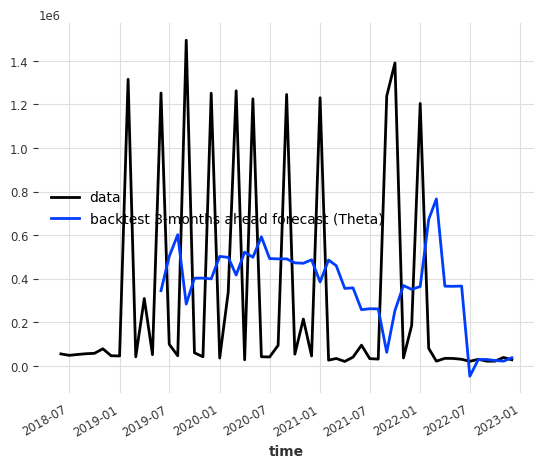

In [105]:
from darts.metrics import mae, mape

historical_fcast = model.historical_forecasts(series, train_length=12, forecast_horizon=1, verbose=True, retrain=True, last_points_only=True)

series.plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast, series)))

In [ ]:
########################
# RUN TIMEGPT HIERARCHICAL
########################
# #split train/test sets
# Y_test_df  = Y_hier_df.groupby('unique_id').tail(fct_periods)
# Y_train_df = Y_hier_df.drop(Y_test_df.index)

# timegpt = TimeGPT(
#     # defaults to os.environ.get("TIMEGPT_TOKEN")
#     token = 'CgM6BBwvTfRrFetlmNCxZzRUAmSRCXndbU1CQJhPryVhgxWp0WgIDIpV9xagvCbg4ZH3TqG012wKMGNs8L7voLeNiydi5U6nFZtnu1P3VJrqECHKzZxCyef8FwNroHEkHM9vR5ltTGAFYW7bOgiiBRzjrdzgk2FIJFsLpXAP9GgMGqa0dVd8it3zbWQ9d02T7JBf9ikAPZyy1bIU206eQZV1Zdd1Rsd9a0PMjUyWxlgg0mckf59d7lwDhzGVBUpd'
# )
# tgpt = timegpt.forecast(Y_train_df, h=fct_periods, freq='MS', time_col='ds', target_col='y', level=[80, 90])

# # Create hierarchical forecast
# tgpt_h = tgpt.set_index('unique_id')
# tgpt_h = tgpt_h[['ds', 'TimeGPT']]

# # Reconcile the base predictions
# reconcilers = [
#     TopDown(method='forecast_proportions')
#     # OptimalCombination(method = 'ols', nonnegative=True)
#     # BottomUp()
#     # ERM(method='closed')
# ]

# hrec = HierarchicalReconciliation(reconcilers=reconcilers)
# Y_rec_df_tgpt = hrec.reconcile(Y_hat_df=tgpt_h, Y_df=Y_train_df,
#                           S=S_df, tags=tags)

# # Reset Index and columns
# Y_rec_df_tgpt = Y_rec_df_tgpt.reset_index()
# Y_rec_df_tgpt.columns = ['unique_id', 'ds', 'TGPT','TGPT_H']

# Save data
# Y_rec_df_tgpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/tgpt_results.csv', index=False)

In [106]:
########################
# FEATURE ENGINEERING
########################
import pandas as pd
from darts import TimeSeries
from darts.models import RegressionModel
from darts.dataprocessing.transformers import Scaler
from lightgbm import LGBMRegressor
from darts.models import LightGBMModel
from darts import concatenate
from sklearn.preprocessing import LabelEncoder

# Feature Engineering
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_output.csv'
features = pd.read_csv(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/price_output.csv'
price = pd.read_csv(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)

import pandas as pd

def prepare_feature(data, r_hier, volume_act2, feature_name):

    # Select and rename columns
    data = data[['cost_object', 'product', 'ds', feature_name]].rename(columns={feature_name: 'y'})

    # Apply any additional preparation (assuming prepare_data is a function you have defined)
    data = prepare_data(data, r_hier)

    # Rename the columns back
    data = data.rename(columns={'y': feature_name})

    # Merge with the volume_act2 dataframe
    merged_df = data.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

    return merged_df


sga1 = prepare_feature(sga, r_hier, volume_act2, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act2, 'Field_Sales')
sga3 = prepare_feature(sga, r_hier, volume_act2, 'Smoothed_AP')
sga4 = prepare_feature(sga, r_hier, volume_act2, 'Smoothed_Field_Sales')

price1 = prepare_feature(price, r_hier, volume_act2, 'Price')
price2 = prepare_feature(price, r_hier, volume_act2, 'Smoothed_Price')


features = features[['cost_object', 'product', 'ds', 'value']]
features.rename(columns={'value': 'y'}, inplace=True)
features = prepare_data(features, r_hier)
features = features.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

# Encoding 'cost_object' and 'product'
label_encoder = LabelEncoder()
features['region'] = label_encoder.fit_transform(features['level2'])
features['cost_object'] = label_encoder.fit_transform(features['level3'])
features['product'] = label_encoder.fit_transform(features['bottom_level'])
features = features[['unique_id', 'ds', 'region', 'cost_object', 'product', 'top_level']]

<ipython-input-106-ce63a970d11e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns={'value': 'y'}, inplace=True)


In [114]:
########################
# RUN LGBM
########################
#split train/test sets
test_ml = volume_act2.groupby('unique_id').tail(fct_periods)
train_ml = volume_act2.drop(test.index)

# Define target column
target_column = 'y'

# Prepare individual time series for each 'unique_id',
time_series_dict = {}
for uid in train_ml['unique_id'].unique():
    df = train_ml[train_ml['unique_id'] == uid].sort_values('ds')

    # Create a TimeSeries object for combined features
    combined_df = df[['ds', 'y']]
    time_series_dict[uid] = TimeSeries.from_dataframe(combined_df, 'ds', target_column)

# Prepare individual time series for dynamic features
dynamic_features_dict = {}
for uid in sga1['unique_id'].unique():
    df1 = sga1[sga1['unique_id'] == uid].sort_values('ds')
    df2 = sga2[sga2['unique_id'] == uid].sort_values('ds')
    df3 = sga3[sga3['unique_id'] == uid].sort_values('ds')
    df4 = sga4[sga4['unique_id'] == uid].sort_values('ds')
    df5 = price1[price1['unique_id'] == uid].sort_values('ds')
    df6 = price2[price2['unique_id'] == uid].sort_values('ds')

    # Create a TimeSeries object for features
    ts1 = TimeSeries.from_dataframe(df1[['ds', 'AP']], 'ds', 'AP')
    ts2 = TimeSeries.from_dataframe(df2[['ds', 'Field_Sales']], 'ds', 'Field_Sales')
    ts3 = TimeSeries.from_dataframe(df3[['ds', 'Smoothed_AP']], 'ds', 'Smoothed_AP')
    ts4 = TimeSeries.from_dataframe(df4[['ds', 'Smoothed_Field_Sales']], 'ds', 'Smoothed_Field_Sales')
    ts5 = TimeSeries.from_dataframe(df5[['ds', 'Price']], 'ds', 'Price')
    ts6 = TimeSeries.from_dataframe(df6[['ds', 'Smoothed_Price']], 'ds', 'Smoothed_Price')

    # Concatenate the two TimeSeries along the feature axis (axis=1)
    combined_ts = concatenate([ts1, ts2, ts3, ts6], axis=1)
    # combined_ts = concatenate([ts3], axis=1)

    # Store the combined TimeSeries in the dictionary
    dynamic_features_dict[uid] = combined_ts



# Create and train a regression model for each time series
models = {}
scalers = {}
forecasts = {}
for uid, ts_combined in time_series_dict.items():
    # Scale the combined series
    scaler = Scaler()
    ts_combined_transformed = scaler.fit_transform(ts_combined)
    scalers[uid] = scaler  # Store scaler for later inverse transformation

    # Initialize and fit your LightGBM model
    model = LightGBMModel(lags=len(ts_combined) // 2, output_chunk_length=1, verbose=-1, lags_past_covariates=12)
    model.fit(series=ts_combined_transformed, past_covariates=dynamic_features_dict[uid])

    # model = LightGBMModel(lags=len(ts_combined) // 2, output_chunk_length=1, verbose=-1)
    # model.fit(series=ts_combined_transformed)

    models[uid] = model

    # Generate forecasts
    forecast = model.predict(n=fct_periods, series=ts_combined_transformed)
    forecasts[uid] = scalers[uid].inverse_transform(forecast)  # Inverse transform to get back to original scale


# Convert forecasts to df
lgbm_fct = convert_fct2df(forecasts)

# Update micafungin sodium
mic_sod_ids = volume_act2[volume_act2['bottom_level']=='MICAFUNGIN - Micafungin Sodium']['unique_id'].unique().tolist()
lgbm_fct.loc[(lgbm_fct['unique_id'].isin(mic_sod_ids)) & (lgbm_fct['ds'] > '2023-06-01'), 'y'] = 0
lgbm_fct.head()

,unique_id,ds,y
0,global/North America/D_E_CA - Canada/AMPHOTERC...,2023-01-01,"320,990.15"
1,global/North America/D_E_CA - Canada/AMPHOTERC...,2023-02-01,"488,671.03"
2,global/North America/D_E_CA - Canada/AMPHOTERC...,2023-03-01,"396,448.77"
3,global/North America/D_E_CA - Canada/AMPHOTERC...,2023-04-01,"325,069.72"
4,global/North America/D_E_CA - Canada/AMPHOTERC...,2023-05-01,"546,939.76"


In [108]:
########################
# FIND IDS WITH SPEND
########################
# Assuming sga is your dataframe
# Group by 'ID' and sum 'AP' and 'Field_Sales'
grouped1 = sga1.groupby('unique_id')[['AP']].sum()
grouped2 = sga2.groupby('unique_id')[['Field_Sales']].sum()

# Find IDs where both 'AP' and 'Field_Sales' are greater than zero
filtered_ids = set(grouped1[(grouped1['AP'] > 0)].index.tolist() + grouped2[(grouped2['Field_Sales'] > 0)].index.tolist())

In [116]:
########################
# METRICS
########################
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/tgpt_results.csv'
tgpt_fct = pd.read_csv(inputFile)
tgpt_fct['ds'] = pd.to_datetime(tgpt_fct['ds'])

# Subset
volume_act_xsm = volume_act[['unique_id', 'ds', 'y']]
volume_act_sm = volume_act2[['unique_id', 'ds', 'y']]
budget2 = budget[['unique_id', 'ds', 'y']]
tgpt_fct = tgpt_fct[['unique_id', 'ds', 'TGPT']]

# Assign names
volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
budget2.rename(columns={'y': 'Budget'}, inplace=True)
volume_act_sm.rename(columns={'y': 'Smoothed'}, inplace=True)
lgbm_fct.rename(columns={'y': 'LGBM'}, inplace=True)
ets_fct.rename(columns={'y': 'Forecast'}, inplace=True)

# Merge actuals, budget and forecast
rev_at = volume_act_xsm.merge(ets_fct, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(volume_act_sm, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(budget2, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(lgbm_fct, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(tgpt_fct, on=['unique_id', 'ds'], how='left')

# Create ensemble
rev_at['Ensemble'] = rev_at[['Forecast', 'LGBM']].mean(axis=1)

# Assuming rev_at is your dataframe, filtered_ids is your list of IDs
rev_at['SelectedFCT'] = np.where(rev_at['unique_id'].isin(filtered_ids), rev_at['LGBM'], rev_at['Forecast'])


# Only keep tested ts
rev_at = rev_at[rev_at['unique_id'].isin(tested_ts)]

rev_at = rev_at[rev_at['unique_id'].isin(volume_act['unique_id'].unique())]




# Filter for dates
data4metrics = rev_at[(rev_at['ds']<=fct_end_date) & (rev_at['ds']>=fct_st_date)]

# Sum up the values for each unique_id
numeric_cols = data4metrics.columns.drop(['unique_id', 'ds'])
summed_df = data4metrics.groupby('unique_id')[numeric_cols].sum()

# Calculate difference and percentage differences from 'Actuals'
absolute_diff = summed_df.subtract(summed_df['Actuals'], axis=0).abs()
percentage_diff = summed_df.subtract(summed_df['Actuals'], axis=0).div(summed_df['Actuals'], axis=0).abs()

# Drop the 'Actuals' column as we don't need to compare it with itself
absolute_diff.drop(columns=['Actuals', 'Smoothed', 'LGBM', 'TGPT', 'Ensemble', 'SelectedFCT'], inplace=True)

# Find the column with the lowest difference for each unique_id and add to metrics table
min_diff_col = absolute_diff.idxmin(axis=1)
data4metrics['lowest_diff_col'] = data4metrics['unique_id'].map(min_diff_col)

# Find winner
winner = data4metrics.groupby('lowest_diff_col')

# Get Budget winners
bud_winners = winner.get_group('Budget')['unique_id'].unique()

winner['unique_id'].nunique()

<ipython-input-116-38b82d8710b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
<ipython-input-116-38b82d8710b9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget2.rename(columns={'y': 'Budget'}, inplace=True)
<ipython-input-116-38b82d8710b9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_act_sm.rename(columns={'y': 'Smoothed'}, inplace=True)
<ipython-inp

lowest_diff_col
Budget      78
Forecast    63
Name: unique_id, dtype: int64

In [117]:
########################
# CREATE PLOT DATA
########################
fct_st_date = pd.to_datetime(fct_st_date)

# Add revenue actuals
data2plot = rev_at.copy()
data2plot['ds'] = pd.to_datetime(data2plot['ds'])

# Update Actuals columns
data2plot['Actuals (Train)'] = data2plot['Actuals'].copy()
data2plot['Actuals'] = data2plot.apply(lambda row: row['Actuals'] if row['ds'] >= fct_st_date else None, axis=1)
data2plot['Actuals (Train)'] = data2plot.apply(lambda row: row['Actuals (Train)'] if row['ds'] < fct_st_date else None, axis=1)

# Filter to end date
data2plot = data2plot[data2plot['ds']<=fct_end_date]

# Find TS to fix
ts2fix = data2plot[data2plot['unique_id'].isin(bud_winners)]

data2plot.head()

,unique_id,ds,Actuals,Forecast,Smoothed,Budget,LGBM,TGPT,Ensemble,SelectedFCT,Actuals (Train)
0,global/North America/D_E_CA - Canada/AMPHOTERC...,2014-04-01,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00
1,global/North America/D_E_CA - Canada/AMPHOTERC...,2014-05-01,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00
2,global/North America/D_E_CA - Canada/AMPHOTERC...,2014-06-01,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00
3,global/North America/D_E_CA - Canada/AMPHOTERC...,2014-07-01,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00
4,global/North America/D_E_CA - Canada/AMPHOTERC...,2014-08-01,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.00


In [118]:
########################
# PLOT
########################
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import base64
from io import BytesIO

# Update the function to include filtering based on 'unique_id'
def plot_data(unique_id):
    # Define x_column and y_columns directly
    x_column = data2use.columns[1]
    y_columns = [data2use.columns[2], data2use.columns[3], data2use.columns[5], data2use.columns[6], data2use.columns[7], data2use.columns[8], data2use.columns[9], data2use.columns[10]]

    # Filter data based on selected unique_id
    filtered_data = data2plot[data2plot['unique_id'] == unique_id]

    # Set up a 1x3 grid of subplots
    fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [4, 1]}) # Adjust layout for table

    # Plotting multiple y-axes on the first subplot
    for y_column in y_columns:
        ax1.plot(filtered_data[x_column], filtered_data[y_column], label=y_column)
    ax1.set_xlabel(x_column)
    ax1.set_ylabel('Values')
    ax1.set_title(f'Revenue for {unique_id}')
    ax1.legend()

    # Remove axis for table
    ax4.axis('off')
    ax4.axis('tight')

    # Displaying the sum table
    display_data = filtered_data[[x_column] + list(y_columns)].copy()
    display_data = display_data[display_data['ds']>=fct_st_date]
    display_data['ds'] = display_data['ds'].dt.strftime('%m/%d/%Y')

    # Create a sum row
    sum_values = {x_column: 'Sum'}
    for col in list(y_columns):
        sum_values[col] = display_data[col].sum()
    sum_row = pd.DataFrame([sum_values])

    # Create a % diff row
    actuals_sum = sum_values['Actuals']
    pdiff_values = {x_column: '% Diff'}
    for col in list(y_columns):
        pdiff_values[col] = ((display_data[col].sum()-actuals_sum) / actuals_sum) * 100 if actuals_sum != 0 else None
        pdiff_values[col] = round(pdiff_values[col], 2)
    perc_diff_row = pd.DataFrame([pdiff_values])

    # Stack the sum row
    display_data = pd.concat([sum_row, display_data], ignore_index=True)

    # Round the values and add commas
    for column in y_columns:
        if column in display_data.columns:
            # Round to two decimal places
            display_data[column] = display_data[column].round(2)
            # Format with commas
            display_data[column] = display_data[column].apply(lambda x: f"{x:,.2f}")

    # Stack the % diff and remove 'Actuals Train'
    display_data = pd.concat([perc_diff_row, display_data], ignore_index=True)
    display_data = display_data.drop('Actuals (Train)', axis=1)

    # Convert perc_diff_data to array for table
    table_data = display_data.to_numpy()
    # Add table at the right
    table = ax4.table(cellText=table_data, colLabels=display_data.columns, loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(8.5)  # Set smaller font size if necessary
    table.scale(4, 1.8)  # Adjust scale to fit

    plt.tight_layout()
    plt.show()


data2use = ts2fix
# data2use = data2plot

# Create widgets
unique_id_selector = widgets.SelectionSlider(
    options=data2use['unique_id'].unique(),
    description='unique_id:',
    orientation='horizontal',
    readout=True
)

# Display interactive plot
interact(plot_data, unique_id=unique_id_selector)

interactive(children=(SelectionSlider(description='unique_id:', options=('global/North America/D_E_CA - Canada…

<function __main__.plot_data(unique_id)>

In [ ]:
####################
# CREATE FINAL DF AND SAVE DATA
####################
volume_fct = data4metrics[data4metrics['unique_id'].isin(tested_ts)]

volume_fct = volume_fct[['unique_id', 'ds', 'Forecast','Actuals', 'Budget', 'lowest_diff_col']]

# Sum up the values for each unique_id
numeric_cols = volume_fct.columns.drop(['unique_id', 'ds', 'lowest_diff_col'])
volume_sum = volume_fct.groupby('unique_id')[numeric_cols].sum()

# Calculate difference and percentage differences from 'Actuals'
absolute_diff = volume_sum.subtract(volume_sum['Actuals'], axis=0).abs()
percentage_diff = volume_sum.subtract(volume_sum['Actuals'], axis=0).div(volume_sum['Actuals'], axis=0).abs()

# Drop uneeded columns
absolute_diff.drop(columns=['Actuals', 'Budget'], inplace=True)

# Find the column with the lowest difference for each unique_id and add to metrics table
min_diff_col = absolute_diff.idxmin(axis=1)
volume_fct['lowest_diff_col'] = volume_fct['unique_id'].map(min_diff_col)

# Define a function to apply to each row
def get_value_from_column(row):
    return row[row['lowest_diff_col']]

# Apply this function to each row
volume_fct['fct'] = volume_fct.apply(get_value_from_column, axis=1)

# Select columns
volume_fct = volume_fct[['unique_id', 'ds','fct']]

volume_fct.to_csv('/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_fct.csv', index=False)